In [ ]:
pip install -r requirements.txt

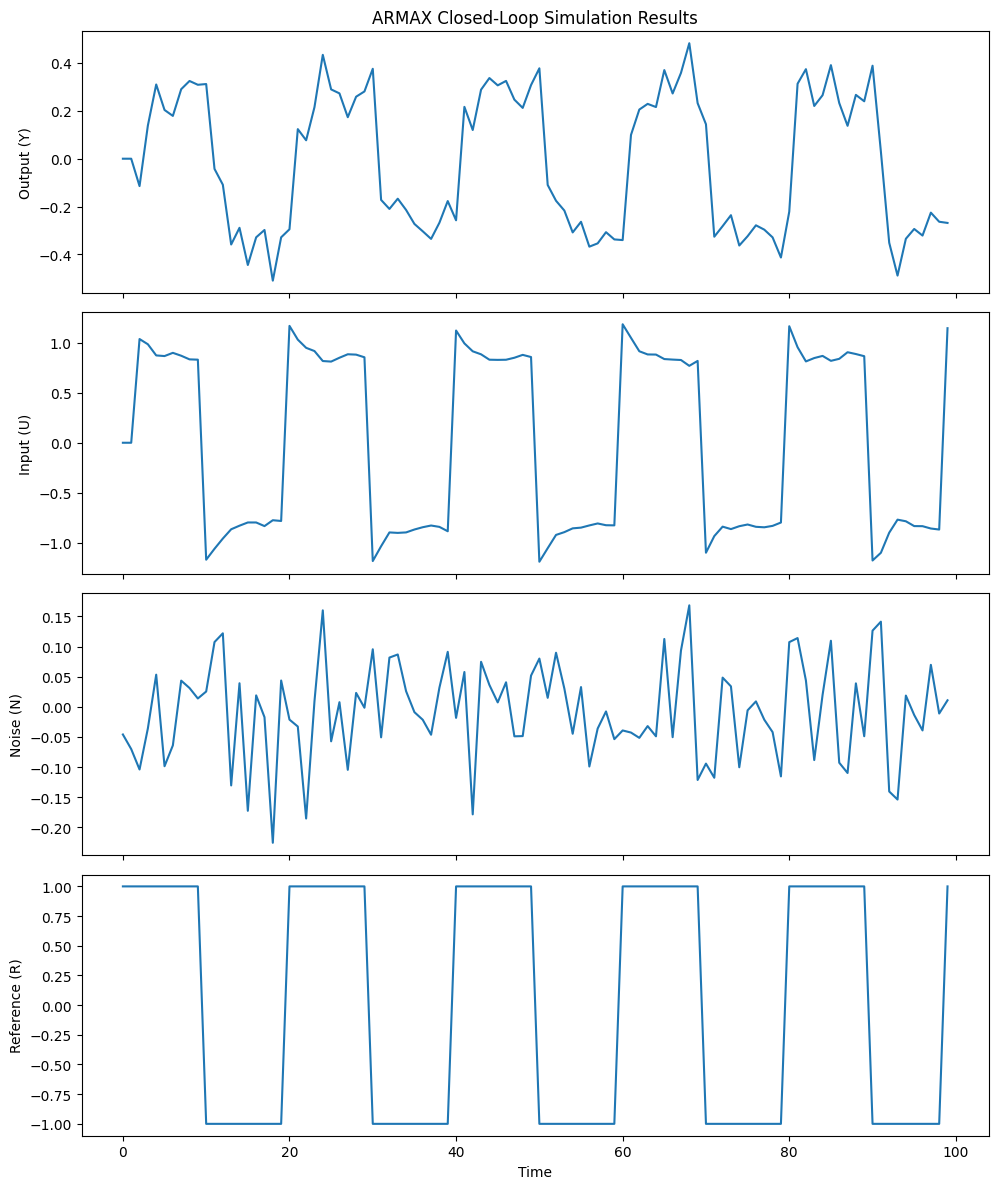

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

class ARMAX:
    def __init__(self, A, B, C, F, L):
        self.A = np.array(A)
        self.B = np.array(B)
        self.C = np.array(C)
        self.F = np.array(F)
        self.L = np.array(L)
    
    def simulate(self, n_samples, R=None, noise_std=0.1):
        Y = np.zeros(n_samples)
        U = np.zeros(n_samples)
        N = np.random.normal(0, noise_std, n_samples)
        
        if R is None:
            R = np.zeros(n_samples)
        
        max_order = max(len(self.A), len(self.B), len(self.C), len(self.F), len(self.L))
        
        for t in range(max_order, n_samples):
            Y[t] = (- np.dot(self.A[1:], Y[t-1:t-len(self.A):-1]) 
                    + np.dot(self.B, U[t-1:t-len(self.B)-1:-1])
                    + np.dot(self.C, N[t:t-len(self.C):-1]))
            
            U[t] = (np.dot(self.L, R[t:t-len(self.L):-1]) 
                    - np.dot(self.F, Y[t:t-len(self.F):-1]))
        
        return Y, U, N, R
    
    def plot_results(self, Y, U, N, R):
        fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
        
        axs[0].plot(Y)
        axs[0].set_ylabel('Output (Y)')
        axs[0].set_title('ARMAX Closed-Loop Simulation Results')
        
        axs[1].plot(U)
        axs[1].set_ylabel('Input (U)')
        
        axs[2].plot(N)
        axs[2].set_ylabel('Noise (N)')
        
        axs[3].plot(R)
        axs[3].set_ylabel('Reference (R)')
        axs[3].set_xlabel('Time')
        
        plt.tight_layout()
        plt.show()

# Example usage
A = [1, -0.33]  # A(z^-1) = 1 - 0.33z^-1
B = [0.22]      # B(z^-1) = 0.22z^-1
C = [1, 0.15]   # C(z^-1) = 1 + 0.15z^-1
F = [0.31, 0.23] # F(z^-1) = 0.31 + 0.23z^-1
L = [1]        # L(z^-1) = 1

armax_model = ARMAX(A, B, C, F, L)

n_samples = 100
# square wave reference signal
R = signal.square(np.linspace(0, 10*np.pi, n_samples))

Y, U, N, R = armax_model.simulate(n_samples, R)
armax_model.plot_results(Y, U, N, R)


In [100]:
import numpy as np
from scipy.signal import lti, convolve
from scipy.signal import TransferFunction, lfilter
from scipy.linalg import sqrtm, pinv

class d_tfs:
    def __init__(self, A):
        self.num = np.array(A[0])  # Convert to numpy array
        self.den = np.array(A[1])  # Convert to numpy array
        self.transfer_function = TransferFunction(self.num, self.den)
    
    def __mul__(self, other):
        # Multiply two transfer functions
        num = convolve(self.num, other.num)
        den = convolve(self.den, other.den)
        return d_tfs((num, den))
    
    def __add__(self, other):
        # Add two transfer functions (polynomial addition)
        num = np.polynomial.polynomial.polyadd(self.num, other.num)
        den = np.polynomial.polynomial.polyadd(self.den, other.den)
        return d_tfs((num, den))
    
    def __truediv__(self, other):
        # Divide two transfer functions
        num = convolve(self.num, other.den)
        den = convolve(self.den, other.num)
        return d_tfs((num, den))
    
    def __invert__(self):
        # Invert a transfer function
        return d_tfs((self.den, self.num))
    
    def __str__(self):
        return f"Transfer Function: num={self.num}, den={self.den}"
    
    def __repr__(self):
        return self.__str__()
    
    def __call__(self, z):
        # Evaluate transfer function at z
        return np.polyval(self.num, z) / np.polyval(self.den, z)
    
    def apply_shift_operator(self, U_t):
        """
        Efficiently apply the current transfer function as a shift operator to the time series U_t.
        Uses scipy's lfilter for filtering the input signal using the transfer function.
        """
        # Apply the transfer function to the time series using lfilter
        Y_t = lfilter(self.num, self.den, U_t)  # _ captures the state output
        return Y_t


# Define a class for the SPS indirect model
class SPS_indirect_model:
    def __init__(self, m, q, T):
        self.m  = m
        self.q = q
        self.T = T
        self.alpha = np.random.choice([-1, 1], size=(m-1, T))
        #Generate a random permutation π of the set
        self.pi_order = np.random.permutation(np.arange( m))

    def transform_to_open_loop(self, G, H, F, L):
        """
        Transform closed-loop system to open-loop system using custom transfer function class.

        Closed loop system:
        Y_t = G(z^-1)U_t + H(z^-1)N_t
        U_t = L(z^-1)R_t - F(z^-1)Y_t
        
        Open loop system:
        Y_t = G_0(z^-1)R_t + H_0(z^-1)N_t
        G_0 = (1 + G(z^-1)F(z^-1))^-1 G(z^-1)L(z^-1)
        H_0 = (1 + G(z^-1)F(z^-1))^-1 H(z^-1)
        """
        # G, H, F, and L are tuples (numerator, denominator) for discrete-time transfer functions
        G = d_tfs(G)
        H = d_tfs(H)
        F = d_tfs(F)
        L = d_tfs(L)
        I = d_tfs(([1], [1]))  # Unity transfer function (1)

        # Compute the open-loop G_0(z^-1) and H_0(z^-1)
        GF_plus_I = (G * F) + I  # G(z^-1) * F(z^-1) + 1
        i_GF_plus_I = ~GF_plus_I  # (1 + G(z^-1)F(z^-1))^-1
        G_0 = i_GF_plus_I * G * L  # G_0 = (1 + G(z^-1)F(z^-1))^-1 * G(z^-1)L(z^-1)
        H_0 = i_GF_plus_I * H  # H_0 = (1 + G(z^-1)F(z^-1))^-1 * H(z^-1)
        return G_0, H_0
    
    def open_loop_sps(self, G_0, H_0, Y_t, U_t, n_a, n_b):
        """
        Compute the confidence region using open-loop sps method.
        System:
        Y_t = G_0(z^-1)R_t + H_0(z^-1)N_t
        """
        n_samples = len(Y_t)
        # 1. prediction errors 
        # N_hat = H(z)^-1 * (Y_t - G_0(z)*U_t)
        YGU = Y_t - G_0.apply_shift_operator(U_t)
        N_hat = (~H_0).apply_shift_operator(YGU)
        
       # Step 2: Generate m-1 random sign perturbations (alpha_i_t)

        # Compute perturbed prediction errors
        perturbed_N_hat = self.alpha * N_hat  # Element-wise multiplication
        # Step 3: Compute perturbed outputs (y_bar)
        # y_bar = G_0(z^-1)U_t + H_0(z^-1)perturbed_N_hat
        y_bar = []
        for i in range(self.m-1):
            y_i = G_0.apply_shift_operator(U_t) +  H_0.apply_shift_operator(perturbed_N_hat[i])
            y_bar.append(y_i)
        
        y_bar = np.array(y_bar)  # Convert to numpy array for further processing
        # Step 4: form phi_tilde
        # phi_bar = W(z^-1) * y_bar + Q(z^-1) * U_t
        # phi_bar_i,t = [-Y_i,t-1, -Y_i,t-2, ..., -Y_i,t-n_a, U_t-1, U_t-2, ..., U_t-n_b]
        # W(z^-1) = -z^-1 + z^-2 + ... + z^-n_a
        # Q(z^-1) = z^-1 + z^-2 + ... + z^-n_b
        W = ([0] + [-1] * n_a, [1])  # W(z^-1) = -z^-1 - z^-2 - ... - z^-n_a
        Q = ([0] + [1] * n_b, [1])  # Q(z^-1) = z^-1 + z^-2 + ... + z^-n_b
        W = d_tfs(W)
        Q = d_tfs(Q)
        phi_bar = W.apply_shift_operator(y_bar) + Q.apply_shift_operator(U_t)
        phi = W.apply_shift_operator(Y_t) + Q.apply_shift_operator(U_t)
        # vertical stack phi and phi_bar
        phi_tilde = np.vstack((phi, phi_bar))
        # Step 5: Compute the rank matrix
        S = np.zeros(self.m)
        for i in range(self.m):
            # R = 1/n sum_{t=1}^{n} (phi_tilde * phi_tilde^T)
            R_i = np.einsum('i,j->ij', phi_tilde[i], phi_tilde[i]) / n_samples
            # Compute principal square root inverse
            R_root_inv = pinv(sqrtm(R_i))  # Use pseudoinverse if matrix is singular
            # Compute weighted sum for S_i(\theta)
            N_hat_i = N_hat if i == 0 else perturbed_N_hat[i-1]
            weighted_sum = np.sum(N_hat_i * phi_tilde[i])
            # Compute S_i(\theta)
            S_i = R_root_inv * weighted_sum
            S[i] = np.linalg.norm(S_i, ord=2)
        order = np.lexsort((self.pi_order, S))
        rank_R = np.where(order == 0)[0][0]+1
        return rank_R<=self.m-self.q

# Example usage:
# A(z) y_t = B(z) u_t + C(z) n_t
# u_t = L(z) r_t - F(z) y_t
A  = [1, -0.33]         # A(z^-1) = 1 - 0.33z^-1
B =  [0, 0.22]            # B(z^-1) = 0.22z^-1
C =  [1, 0.15]         # C(z^-1) = 1 + 0.15z^-1

G = (B, A)  
H = (C, A)     
F = ([0.31, 0.23], [1])  # F(z^-1) = 0.31 + 0.23z^-1
L = ([1], [1])         # L(z^-1) = 1

m = 24
q = 1
T = n_samples
model = SPS_indirect_model(m, q, T)
G_0, H_0 = model.transform_to_open_loop(G, H, F, L)

# Print the resulting transfer functions
print("G_0(z^-1):", G_0.num, G_0.den)
print("H_0(z^-1):", H_0.num, H_0.den)

model.open_loop_sps(G_0, H_0, Y, U, 1, 1)


G_0(z^-1): [ 0.      0.44   -0.0726] [ 1.       -0.2618    0.028094 -0.016698]
H_0(z^-1): [ 2.     -0.03   -0.0495] [ 1.       -0.2618    0.028094 -0.016698]


np.True_

In [34]:
W = ([0] + [1] * 4, [1]) 
print(W)

([0, 1, 1, 1, 1], [1])
